In [16]:
using MGVInference

In [2]:
fft_gp_model = "../test/test_models/fft_gp.jl"
open(fft_gp_model, "r") do io
    map(println, readlines(io))
end
include(fft_gp_model)

# This file is a part of MGVInference.jl, licensed under the MIT License (MIT).

import Base: *, adjoint
import AbstractFFTs
import FFTW: plan_r2r, DHT
import ForwardDiff
import Random: randn, MersenneTwister
import Distributions: Normal
import ValueShapes: NamedTupleDist
import Zygote
import LinearAlgebra: Diagonal

_dims = 40
_k = [i < _dims / 2 ? i : _dims-i for i = 0:_dims-1]

# Define the harmonic transform operator as a matrix-like object
_ht = plan_r2r(zeros(_dims), DHT)

# Unfortunately neither Zygote nor ForwardDiff support planned Hartley
# transformations. While Zygote does not support AbstractFFTs.ScaledPlan,
# ForwardDiff does not overload the appropriate methods from AbstractFFTs.
function _plan_dual_product(trafo::AbstractFFTs.Plan, u::Vector{ForwardDiff.Dual{T, V, N}}) where {T, V, N}
    # Unpack AoS -> SoA
    vs = ForwardDiff.value.(u)
    ps = mapreduce(ForwardDiff.partials, hcat, u)
    # Actual computation
    val = trafo * vs
    jvp = [trafo*t[:] for t in eachro

40-element Array{Float64,1}:
 -0.2182971373018973
 -1.7218447499307976
  0.603715678803879
 -0.21179751899630508
 -0.44777338300787084
 -0.4476889572053994
  2.013315941253755
  0.7635310957132931
 -0.0981351745482496
  0.14246898420247958
 -2.893510412007984
  0.271258492099812
  0.49524834448070404
  ⋮
  1.7356116899036684
  1.8546456957399085
  0.2265671769535978
  0.2545780573368525
 -0.1958819956230198
 -0.3239403481351395
  0.21917922464094056
 -0.3926885430284329
 -0.31484314959998216
  2.2659326905628294
 -0.289867554971233
  1.0991094524324592

In [3]:
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [4]:
data = rand(model(true_params), 1)[1];

In [5]:
_common_grid = [1:_dims...];

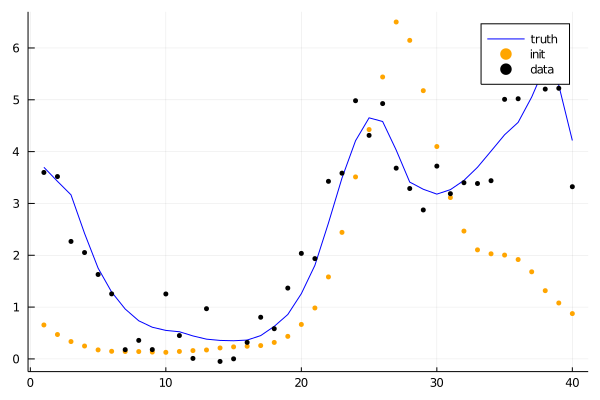

In [6]:
init_plots =() -> let
    truth = _mean(true_params)
    plot!(_common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(_common_grid, _mean(starting_point), markercolor=:orange, markerstrokewidth=0, markersize=3, label="init")
    scatter!(_common_grid, MGVInference.unshaped(data), markercolor=:black, markerstrokewidth=0, markersize=3, label="data")
end
plot()
init_plots()

In [17]:
first_iteration = mgvi_kl_optimize_step(model, data, starting_point; jacobian_func=FwdRevADJacobianFunc, residual_sampler=ImplicitResidualSampler)

display(hcat(first_iteration, true_params))

40×2 Array{Float64,2}:
  0.375932    0.48151
 -0.921498   -0.564916
  1.58681     1.63042
 -0.797029   -1.14073
  0.269954    0.867529
 -0.076442    0.0598623
 -0.419825   -1.64938
  0.533435   -0.552528
  0.166189   -0.472529
 -0.135045   -0.468033
  0.0605472  -0.200177
  0.224222   -0.944585
  0.0247361   0.75603
  ⋮          
 -0.18348    -0.268811
 -0.19334     0.0891861
 -0.348547   -2.73701
 -0.072494   -1.57267
  0.219153   -0.859427
 -0.487564   -0.795277
 -0.906225   -0.75824
 -0.323689   -0.572864
 -0.552876   -0.559156
  0.566924    0.841274
  1.07796     0.298653
  1.25664     1.25313

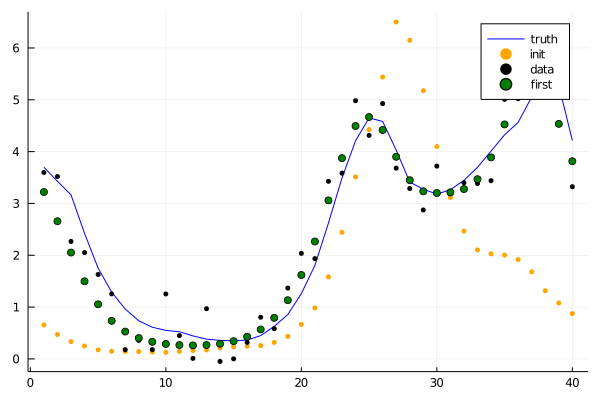

In [18]:
plot_iteration = (params, label) -> let
    #error_mat = mgvi_kl_errors(full_model, params)
    #display(error_mat)
    #errors = sqrt.(error_mat[diagind(error_mat)])
    #yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    #scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
    scatter!(_common_grid, _mean(params), markercolor=:green, label=label)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [19]:
plot_iteration_light = (params, counter) -> let
    scatter!(_common_grid, _mean(params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#25 (generic function with 1 method)

40×2 Array{Float64,2}:
  0.375932    0.48151
 -0.921498   -0.564916
  1.58681     1.63042
 -0.797029   -1.14073
  0.269954    0.867529
 -0.076442    0.0598623
 -0.419825   -1.64938
  0.533435   -0.552528
  0.166189   -0.472529
 -0.135045   -0.468033
  0.0605472  -0.200177
  0.224222   -0.944585
  0.0247361   0.75603
  ⋮          
 -0.18348    -0.268811
 -0.19334     0.0891861
 -0.348547   -2.73701
 -0.072494   -1.57267
  0.219153   -0.859427
 -0.487564   -0.795277
 -0.906225   -0.75824
 -0.323689   -0.572864
 -0.552876   -0.559156
  0.566924    0.841274
  1.07796     0.298653
  1.25664     1.25313

40×2 Array{Float64,2}:
  0.425323    0.48151
 -0.799981   -0.564916
  1.78249     1.63042
 -0.916253   -1.14073
  0.081732    0.867529
 -0.172302    0.0598623
 -0.520033   -1.64938
  0.513399   -0.552528
  0.16967    -0.472529
 -0.115923   -0.468033
  0.0752555  -0.200177
  0.237764   -0.944585
  0.0327005   0.75603
  ⋮          
 -0.196587   -0.268811
 -0.205061    0.0891861
 -0.35488    -2.73701
 -0.0648482  -1.57267
  0.243632   -0.859427
 -0.523515   -0.795277
 -0.887061   -0.75824
 -0.393588   -0.572864
 -0.543307   -0.559156
  0.230616    0.841274
  0.904598    0.298653
  1.26498     1.25313

40×2 Array{Float64,2}:
  0.441172    0.48151
 -0.785474   -0.564916
  1.70832     1.63042
 -0.868173   -1.14073
  0.0727029   0.867529
 -0.141894    0.0598623
 -0.568198   -1.64938
  0.520772   -0.552528
  0.157027   -0.472529
 -0.111498   -0.468033
  0.0712991  -0.200177
  0.2496     -0.944585
  0.030753    0.75603
  ⋮          
 -0.191455   -0.268811
 -0.204987    0.0891861
 -0.358854   -2.73701
 -0.0500197  -1.57267
  0.23572    -0.859427
 -0.492141   -0.795277
 -0.924294   -0.75824
 -0.35239    -0.572864
 -0.588326   -0.559156
  0.291005    0.841274
  0.904438    0.298653
  1.23021     1.25313

40×2 Array{Float64,2}:
  0.460803    0.48151
 -0.758561   -0.564916
  1.63912     1.63042
 -0.894678   -1.14073
  0.0951753   0.867529
 -0.119115    0.0598623
 -0.553794   -1.64938
  0.514979   -0.552528
  0.152353   -0.472529
 -0.114138   -0.468033
  0.0717604  -0.200177
  0.240436   -0.944585
  0.0319656   0.75603
  ⋮          
 -0.200611   -0.268811
 -0.210376    0.0891861
 -0.355846   -2.73701
 -0.0520914  -1.57267
  0.23843    -0.859427
 -0.489657   -0.795277
 -0.916683   -0.75824
 -0.34665    -0.572864
 -0.561601   -0.559156
  0.35392     0.841274
  0.872951    0.298653
  1.19058     1.25313

40×2 Array{Float64,2}:
  0.458634    0.48151
 -0.759262   -0.564916
  1.63238     1.63042
 -0.910975   -1.14073
  0.113132    0.867529
 -0.142547    0.0598623
 -0.531025   -1.64938
  0.511884   -0.552528
  0.151383   -0.472529
 -0.105021   -0.468033
  0.0718871  -0.200177
  0.237459   -0.944585
  0.0297744   0.75603
  ⋮          
 -0.192534   -0.268811
 -0.206396    0.0891861
 -0.348243   -2.73701
 -0.0546777  -1.57267
  0.222769   -0.859427
 -0.490124   -0.795277
 -0.9328     -0.75824
 -0.335683   -0.572864
 -0.556697   -0.559156
  0.36821     0.841274
  0.871114    0.298653
  1.19099     1.25313

40×2 Array{Float64,2}:
  0.454317    0.48151
 -0.768638   -0.564916
  1.65008     1.63042
 -0.875441   -1.14073
  0.109057    0.867529
 -0.170133    0.0598623
 -0.5481     -1.64938
  0.534362   -0.552528
  0.156109   -0.472529
 -0.113154   -0.468033
  0.0735273  -0.200177
  0.244285   -0.944585
  0.0321219   0.75603
  ⋮          
 -0.194212   -0.268811
 -0.213004    0.0891861
 -0.361964   -2.73701
 -0.0615266  -1.57267
  0.248189   -0.859427
 -0.487016   -0.795277
 -0.924444   -0.75824
 -0.359379   -0.572864
 -0.604376   -0.559156
  0.352971    0.841274
  0.88769     0.298653
  1.20112     1.25313

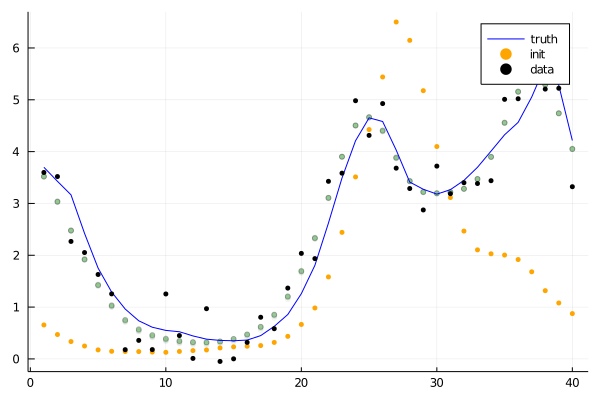

In [20]:
plt = scatter()
next_iteration = first_iteration
for i in 1:5
    display(hcat(next_iteration, true_params))
    next_iteration = mgvi_kl_optimize_step(model, data, next_iteration; jacobian_func=FwdRevADJacobianFunc, residual_sampler=ImplicitResidualSampler)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

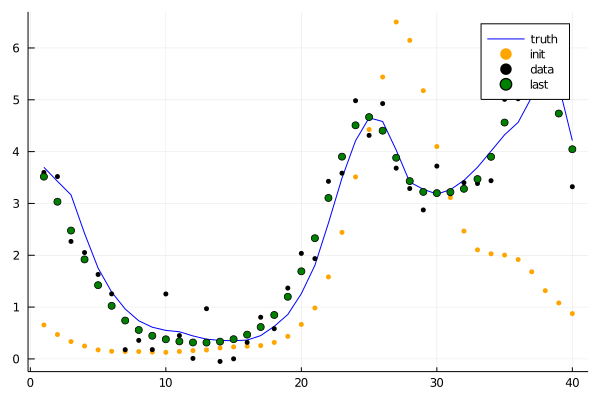

In [21]:
plot()
init_plots()
plot_iteration(next_iteration, "last")